<a href="https://colab.research.google.com/github/nhungab/doanhso/blob/main/B%C3%A3i_%C4%91%E1%BA%ADu_xe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_excel = pd.read_excel('dataset.csv')

In [ ]:
data_excel

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
...,...,...,...,...
35712,Shopping,1920,1517,2016-12-19 14:30:33
35713,Shopping,1920,1487,2016-12-19 15:03:34
35714,Shopping,1920,1432,2016-12-19 15:29:33
35715,Shopping,1920,1321,2016-12-19 16:03:35


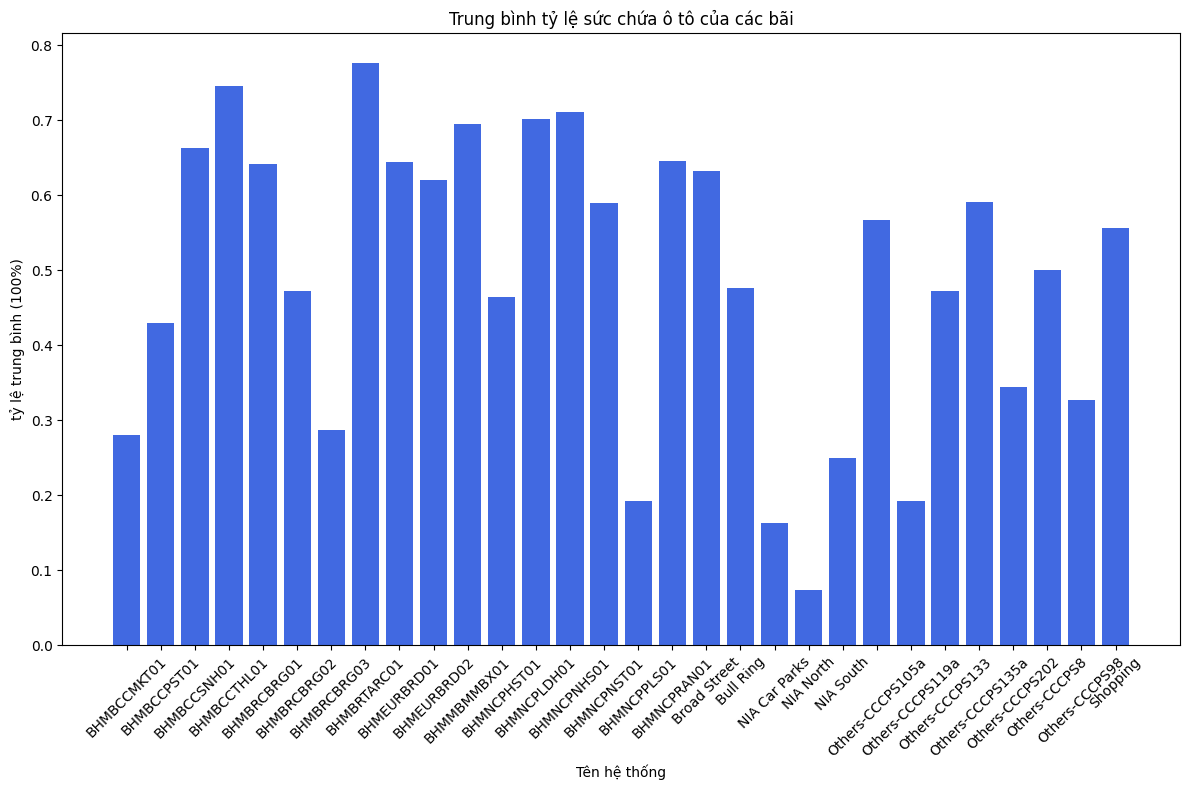

In [ ]:
import matplotlib.pyplot as plt

# Calculate the occupancy rate as a new column
data_excel['Occupancy Rate'] = data_excel['Occupancy'] / data_excel['Capacity']

# Aggregate data to find the average occupancy rate for each parking system
average_occupancy = data_excel.groupby('SystemCodeNumber')['Occupancy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(average_occupancy['SystemCodeNumber'], average_occupancy['Occupancy Rate'], color='royalblue')
plt.xlabel('Tên hệ thống')
plt.ylabel('tỷ lệ trung bình (100%)')
plt.title('Trung bình tỷ lệ sức chứa ô tô của các bãi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Nhìn vào đây để đánh giá xem bãi đậu xe nào hay bị đầy (đây là tỉ lệ phần trăm)

<Axes: xlabel='SystemCodeNumber', ylabel='SystemCodeNumber'>

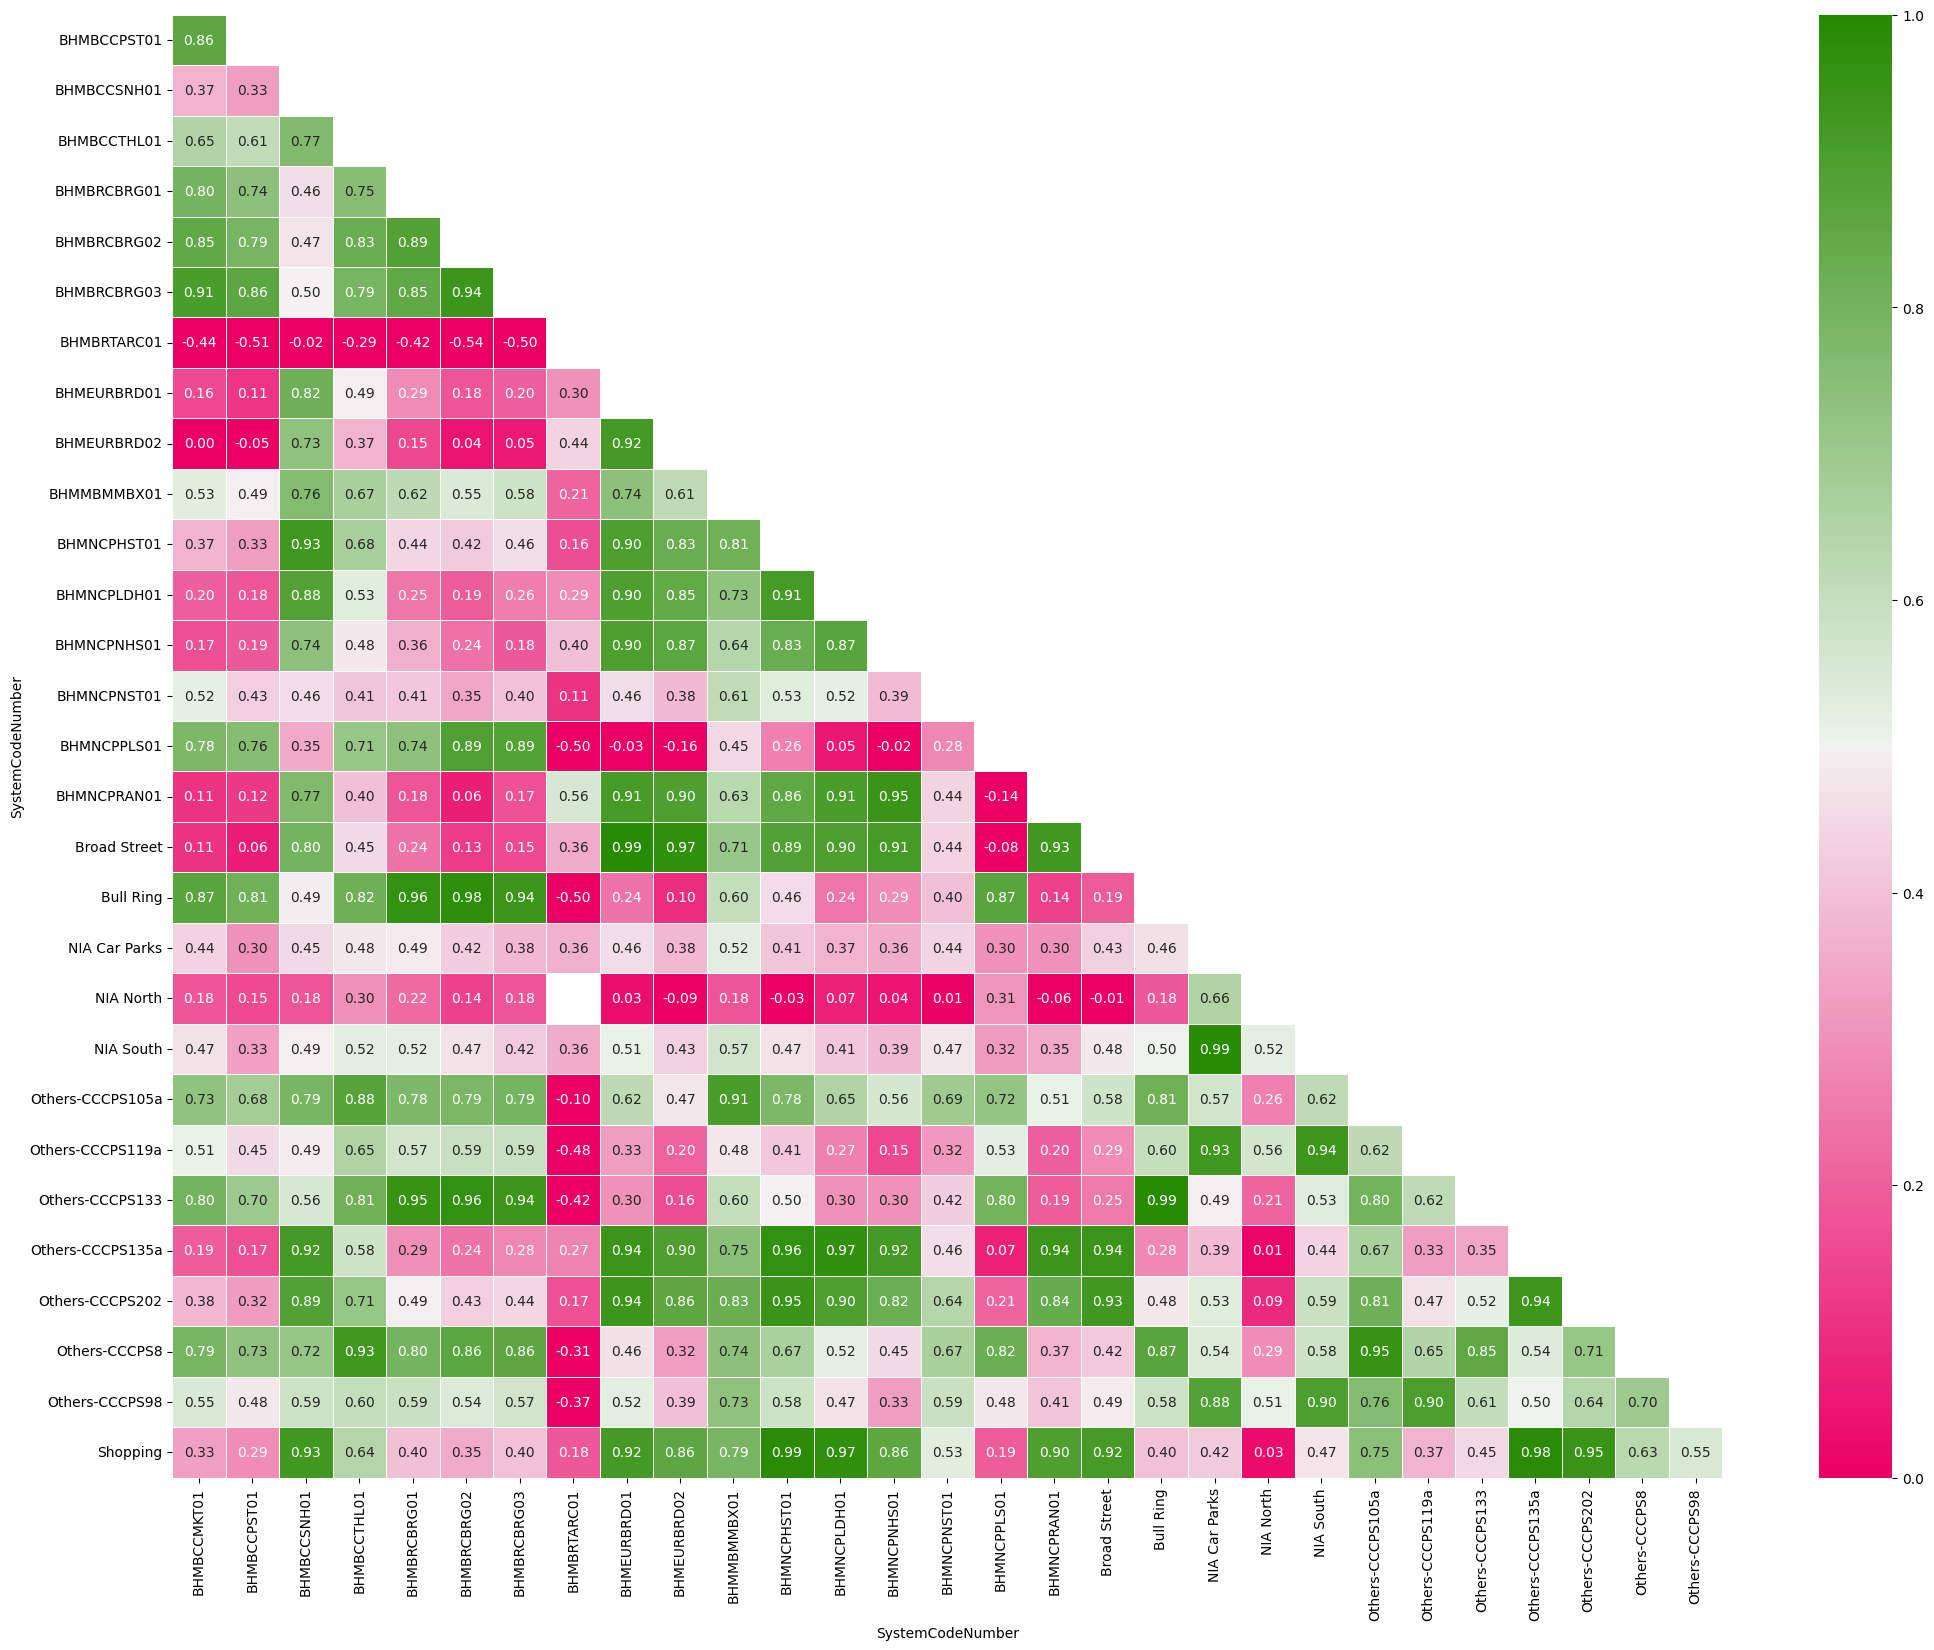

In [ ]:
import seaborn as sns

# Create a pivot table for the occupancy rates of each parking system over time
pivot_data = data_excel.pivot_table(values='Occupancy Rate', index='LastUpdated', columns='SystemCodeNumber')

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()
ones_corr = np.ones_like(correlation_matrix, dtype=bool)
# np's triu: return only upper triangle matrix
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_dsts_corr = correlation_matrix.iloc[1:, :-1]
adjusted_dsts_corr

fig, ax = plt.subplots(figsize=(25,19))

cmap = sns.diverging_palette(0, 125,100,50, as_cmap=True)
sns.heatmap(data=adjusted_dsts_corr, mask=adjusted_mask,
        annot=True, fmt=".2f", cmap=cmap,
        vmin=0, vmax=1, linecolor="white", linewidths=0.5)



BHMEURBRD01 và Broad Street, với giá trị tương quan là 0.991. Đây là một mức độ tương quan cao, cho thấy tỷ lệ chiếm chỗ tại hai bãi đậu xe này có mối liên hệ chặt chẽ với nhau.

In [ ]:
# Identify two parking systems with the strongest positive correlation
max_corr_value = correlation_matrix[correlation_matrix < 1].stack().idxmax()
system1, system2 = max_corr_value

# Extract the occupancy rates for these two systems
system1_data = pivot_data[system1].dropna()
system2_data = pivot_data[system2].dropna()

# # Merging the data for the two systems on the index (time)
merged_data = pd.merge(system1_data, system2_data, left_index=True, right_index=True, suffixes=('_sys1', '_sys2'))

In [ ]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = merged_data[[system1]]
y = merged_data[system2]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1044, 1), (261, 1), (1044,), (261,))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Training a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_linear = linear_model.predict(X_test)

# Calculating RMSE for the linear regression model
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
rmse_linear


0.0368572969201456

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Training a random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating RMSE for the random forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_rf


0.03650751269185539

Dựa trên phân tích hiện tại và bối cảnh của bãi đậu xe, đề xuất một số thuộc tính tiềm ẩn sau có thể cần được thêm vào:

1. **Thời gian của ngày**: Tỷ lệ chiếm chỗ có thể thay đổi đáng kể vào các thời điểm khác nhau trong ngày. Việc thu thập dữ liệu về thời gian chi tiết hơn (ví dụ: sáng, trưa, chiều, tối) có thể giúp phân tích và dự đoán chính xác hơn về nhu cầu sử dụng.

2. **Ngày trong tuần**: Ngày làm việc và cuối tuần có thể có mẫu sử dụng bãi đậu xe khác nhau.

3. **Sự kiện đặc biệt**: Các sự kiện lớn trong khu vực có thể ảnh hưởng đáng kể đến nhu cầu đậu xe. Việc thu thập thông tin về các sự kiện lớn có thể giúp dự đoán chính xác hơn khi có sự kiện.

4. **Thời tiết**: Điều kiện thời tiết có thể ảnh hưởng đến việc lựa chọn phương tiện di chuyển và do đó ảnh hưởng đến nhu cầu sử dụng bãi đậu xe.

5. **Loại phương tiện**: Phân loại dữ liệu dựa trên loại phương tiện (xe máy, ô tô cá nhân, xe tải nhỏ) có thể cung cấp cái nhìn sâu sắc hơn về mẫu sử dụng bãi đậu xe.

Việc thu thập những thông tin này sẽ giúp cải thiện độ chính xác của mô hình dự đoán và cung cấp cái nhìn toàn diện hơn về các yếu tố ảnh hưởng đến nhu cầu đậu xe, từ đó giúp quản lý và tối ưu hóa bãi đậu xe hiệu quả hơn.